In [2]:
import sys
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import sympy
import math

In [3]:
# ax + by = c
def lineFromPoints(P, Q):
    a = Q[1] - P[1]
    b = P[0] - Q[0]
    c = a*(P[0]) + b*(P[1])
    
    return a,b,c

In [4]:
rng = np.random.default_rng()
#points = rng.random((30, 2))
points = np.array([[3.1886,-3.81288],[3.40957,-3.743],[3.5845,-3.8394],[3.7997,-3.9225],[4.21067,-4.26765]]) 
print(points)
print(points.shape)
hull = ConvexHull(points)

[[ 3.1886  -3.81288]
 [ 3.40957 -3.743  ]
 [ 3.5845  -3.8394 ]
 [ 3.7997  -3.9225 ]
 [ 4.21067 -4.26765]]
(5, 2)


[[ 3.1886  -3.81288]
 [ 4.21067 -4.26765]
 [ 3.7997  -3.9225 ]
 [ 3.40957 -3.743  ]]
before
[[-0.45477 -1.02207]
 [ 0.34515  0.41097]
 [ 0.1795   0.39013]
 [ 0.06988 -0.22097]]
[[-2.44695064]
 [ 0.30056337]
 [ 0.84823878]
 [-1.06535146]]
[-4.4408921e-16]
final A and b for half space constraint
[[ 0.45477  1.02207]
 [-0.34515 -0.41097]
 [-0.1795  -0.39013]
 [ 0.06988 -0.22097]]
[[ 2.44695064]
 [-0.30056337]
 [-0.84823878]
 [-1.06535146]]


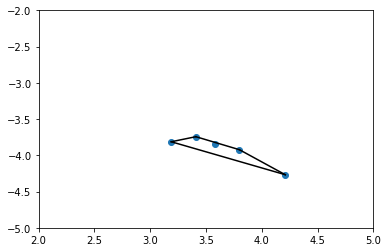

In [5]:
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.xlim(2.0,5.0)
plt.ylim(-5,-2)


# get point from convexhull for polytopic inequ
vertice_points = hull.vertices
#print(vertice_points)

# store points in counter-clockwise
convex_points = []
for i in range(len(vertice_points)):
    convex_points = np.append(convex_points,points[vertice_points[i]])

convex_points = np.reshape(convex_points,(4,2))
print(convex_points)


# get every line equation for generating half space inequaility
a,b,c = lineFromPoints(convex_points[0],convex_points[1])

a_arr = []
b_arr = []
c_arr = []


for i in range(len(convex_points)-1):
    a,b,c = lineFromPoints(convex_points[i],convex_points[i+1])
    a_arr = np.append(a_arr,a)
    b_arr = np.append(b_arr,b)
    c_arr = np.append(c_arr,c)

# store last one
a,b,c = lineFromPoints(convex_points[0],convex_points[len(convex_points)-1])
a_arr = np.append(a_arr,a)
b_arr = np.append(b_arr,b)
c_arr = np.append(c_arr,c)
#print(a_arr)

A = np.zeros((len(convex_points),2))
b = np.zeros((len(convex_points),1))

for i in range(len(a_arr)):
    A[i][0] = a_arr[i]
    A[i][1] = b_arr[i]
    b[i][0] = c_arr[i]

print("before")
print(A)
# make to ax + by + c = 0 
c = - b
print(c)
vector_x = np.array([convex_points[1]]).transpose()
print(A[0] @ vector_x + c[0])
# loop through any other point not on line
# basicially check if ax + by + c >= 0 for all points
for i in range(len(a_arr)):
    for j in range(len(a_arr)):
        if not A[i][0] * convex_points[j][0] + A[i][1] * convex_points[j][1] + c[i] >= -1e-5:
            # if there is one point does not satisfies the inequaility, change sign
            A[i][0] = -A[i][0]
            A[i][1] = -A[i][1]
            c[i] = - c[i]
            break

            
print("final A and b for half space constraint")
print(A)
print(c)

In [85]:
# dynamics changed
# same version but using polytope constraints
x,y,p = sympy.symbols('x y p')
K = 50
V = 1.0
p_d1 = -45*np.pi/180
p_d2 = -20*np.pi/180
p_d3 = 0
p_d4 = 20*np.pi/180
p_d5 = 45*np.pi/180

# use current angle
angle = 0

# taylor approximation around 0 (should be changed later)
# change dynamics to match with global 
f = sympy.Matrix([[V*math.cos(angle) - (V*math.cos(angle)/2)*p**2],[V*math.cos(angle)*p - (V*math.cos(angle))/6*p**3],[V / 0.35 * math.tan(p_d1)]])
#print(f_1)
#print(f_2)
# polynomial basis
b1 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b1 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b1 = sympy.Matrix([[1,x,y,p]]).transpose()


Q = sympy.MatrixSymbol('Q',10,10)
#Q = sympy.MatrixSymbol('Q',4,4)
#Q = sympy.MatrixSymbol('Q',9,9)


# partial derivative
db1_dx = sympy.diff(b1,x)
#print(db1_dx)
db1_dy = sympy.diff(b1,y)
db1_dp = sympy.diff(b1,p)


########## parameterization step
# V
V = (b1.T @ Q @ b1).as_explicit()
SOS_V_para_poly = sympy.Poly(V[0],x,y,p)
B = sympy.Matrix([
            [db1_dx, db1_dy,db1_dp]])
#print(B.shape)
ne_Vdot_compute = (- 2 * b1.T @ Q @ B @ f).as_explicit()
ne_Vdot_compute_poly = sympy.Poly(ne_Vdot_compute[0],x, y, p)

#print('check coeff of ne_Vdot_compute_poly:')
#print(ne_Vdot_compute_poly)
    

# -V_dot
#b2 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
b2 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b2 = sympy.Matrix([[1,x,y,p]]).transpose()
#G = sympy.MatrixSymbol('G', 4, 4)
G = sympy.MatrixSymbol('G', 10, 10)
#G = G = sympy.MatrixSymbol('G', 9, 9)
SOS_of_ne_V_dot = (b2.T @ G @ b2).as_explicit()
SOS_of_ne_V_dot_poly = sympy.Poly(SOS_of_ne_V_dot[0], x, y, p)

#print('\ncheck coeff of SOS_of_ne_V_dot_poly:')
#print(SOS_of_ne_V_dot_poly)

b2_sqr = [b*b for b in b2]
for b_sqr in b2_sqr:
    coeff = SOS_of_ne_V_dot_poly.coeff_monomial(b_sqr)
    if coeff is sympy.S.Zero:
        print('WARNING: digonal coeff is zero for',b_sqr, ' not PSD for sure!')


# define a vector of largrange multiplier
multi_vector = []
J = []
b3 = sympy.Matrix([[1,x,y,p]]).transpose()
SOS_mutiplier_para_v = []
for i in range(len(a_arr)):
    J = sympy.MatrixSymbol('J{}'.format(i),4,4)
    SOS_mutiplier_para = (b3.T @ J @ b3).as_explicit()
    SOS_mutiplier_para_v = np.append(SOS_mutiplier_para_v,SOS_mutiplier_para)
    
SOS_mutiplier_para_v = np.reshape(SOS_mutiplier_para_v,(1,4))
#print(SOS_mutiplier_para_v[0][3])

### dealing with obstacle constraint SOS

# obstacle constraint SOS paratrization
b4 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b4 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b4 = sympy.Matrix([[1,x,y,p]]).transpose()
#M = sympy.MatrixSymbol('M',10,10)
M = sympy.MatrixSymbol('M',10,10)
#M = sympy.MatrixSymbol('M',4,4)
SOS_constraint_para = (b4.T @ M @ b4).as_explicit()
SOS_constraint_para_poly = sympy.Poly(SOS_constraint_para[0],x,y,p)


#print('\ncheck coeff of SOS_constraint_para_poly:{}'.format(SOS_constraint_para_poly))


vector_x = sympy.Matrix([[x,y]]).transpose()
# obstacle constraint SOS computed from V and multiplier
epsilon_1 = 1e-6
SOS_mutiplier_para_poly_v = sympy.Poly((SOS_mutiplier_para_v @ (A @ vector_x + c))[0],x,y,p)

SOS_constraint_compute_poly = SOS_V_para_poly - (1 + epsilon_1) - SOS_mutiplier_para_poly_v
#print(SOS_constraint_compute_poly)
constraint_list_V_Vdot = []
constraint_list_obstacle = []


#print('\ncheck coeff of SOS_constraint_compute_poly:{}'.format(SOS_constraint_compute_poly))



Q = cp.Variable((10,10), symmetric=True)
G = cp.Variable((10,10), symmetric=True)
M = cp.Variable((10,10), symmetric = True)
J0 = cp.Variable((4,4), symmetric = True)
J1 = cp.Variable((4,4), symmetric = True)
J2 = cp.Variable((4,4), symmetric = True)
J3 = cp.Variable((4,4), symmetric = True)
constraints = [G >> 0]
constraints += [M >> 0]
constraints += [J0 >> 0]
constraints += [J1 >> 0]
constraints += [J2 >> 0]
constraints += [J3 >> 0]



max_order = 5
# deal with V and -V_dot adding coeff matching constraint
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            # check if b2.T @ G b2 has coeff
            coeff_V_dot_para = SOS_of_ne_V_dot_poly.coeff_monomial(monomial)
            #print('coeff for {} in SOS_of_ne_V_dot_poly is {}'.format(monomial,coeff_V_dot_para))
            # check if - 2 * b1.T @ Q @ B @ f has coeff
            coeff_V_dot_compu = ne_Vdot_compute_poly.coeff_monomial(monomial)
            #print('coeff for {} in ne_Vdot_compute_poly is {}'.format(monomial,coeff_V_dot_compu))
            
            # continue if both do not contain
            if coeff_V_dot_para is sympy.S.Zero and coeff_V_dot_compu is sympy.S.Zero:
                continue
            
            ## should be modified
            if coeff_V_dot_para is sympy.S.Zero and not coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_V_dot_compu)
                constraint_list_V_Vdot.append(constrain)
                
                constraints += ['{}==0.'.format(coeff_V_dot_compu)]
                
                #constraints += 
            ## should be modified
            if not coeff_V_dot_para is sympy.S.Zero and coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_V_dot_para)
                constraint_list_V_Vdot.append(constrain)
                
                
            if not coeff_V_dot_para is sympy.S.Zero and not coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_V_dot_compu,coeff_V_dot_para)
                constraint_list_V_Vdot.append(constrain)

            
#print('\nConstraints V_Vdot (copy):', ','.join(constraint_list_V_Vdot))                


# delta with obstacle SOS coeff matching
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            
            coeff_constraint_para = SOS_constraint_para_poly.coeff_monomial(monomial)
            coeff_constraint_compute = SOS_constraint_compute_poly.coeff_monomial(monomial)
            
            if coeff_constraint_para is sympy.S.Zero and coeff_constraint_compute is sympy.S.Zero:
                #print(monomial)
                continue
            
            ## should be modified
            if coeff_constraint_para is sympy.S.Zero and not coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_constraint_compute)
                constraint_list_obstacle.append(constrain)
            ## should be modified
            if not coeff_constraint_para is sympy.S.Zero and coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_constraint_para)
                constraint_list_obstacle.append(constrain)
                
            if not coeff_constraint_para is sympy.S.Zero and not coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_constraint_compute,coeff_constraint_para)
                constraint_list_obstacle.append(constrain)

#print('\nConstraints obstacle SOS (copy):', ','.join(constraint_list_obstacle))



ValueError: Problem has an invalid constraint of type <class 'str'>

In [84]:
print(constraints[24])

0.333333333333333*Q[4, 5]==0.


In [68]:
# solve SOS as SDP based on constraint obtained earilier
Q = cp.Variable((10,10), symmetric=True)
G = cp.Variable((10,10), symmetric=True)
M = cp.Variable((10,10), symmetric = True)



# create multipliers (should be changed later based on number of convex points)
J0 = cp.Variable((4,4), symmetric = True)
J1 = cp.Variable((4,4), symmetric = True)
J2 = cp.Variable((4,4), symmetric = True)
J3 = cp.Variable((4,4), symmetric = True)


# make sure positive definite , sufficient condition
#epsilon = 1e-8
#constraints = [Q >> 0]
constraints = [G >> 0]
constraints += [M >> 0]

constraints += [J0 >> 0]
constraints += [J1 >> 0]
constraints += [J2 >> 0]
constraints += [J3 >> 0]



# equaility constraint for initial condition
x_0 = 3.572468
y_0 = -2.9473
p_0 = -1.19

b_0 = np.array([[1,x_0,y_0,p_0,x_0**2,x_0*y_0,y_0**2,x_0*p_0,y_0*p_0,p_0**2]]).transpose()
#print(b_0.T @ Q @ b_0)
#b1 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#constraints += 

constraints += [b_0.T @ Q @ b_0 == 0]


constraints += []

# V Vdot coeff matching constraint

# p_d1 angle = 0
#constraints += [-2.0*Q[0, 1] + 5.71428571428571*Q[0, 3]==G[0, 0],-2.0*Q[0, 2] - 2.0*Q[0, 7] + 11.4285714285714*Q[0, 9] - 2.0*Q[3, 1] + 5.71428571428571*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 1] - 2.0*Q[0, 8] - 2.0*Q[3, 2] - 2.0*Q[3, 7] + 11.4285714285714*Q[3, 9] - 2.0*Q[9, 1] + 5.71428571428571*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],0.333333333333333*Q[0, 2] + 1.0*Q[0, 7] + 1.0*Q[3, 1] - 2.0*Q[3, 8] - 2.0*Q[9, 2] - 2.0*Q[9, 7] + 11.4285714285714*Q[9, 9]==G[3, 9] + G[9, 3],0.333333333333333*Q[0, 8] + 0.333333333333333*Q[3, 2] + 1.0*Q[3, 7] + 1.0*Q[9, 1] - 2.0*Q[9, 8]==G[9, 9],0.333333333333333*Q[3, 8] + 0.333333333333333*Q[9, 2] + 1.0*Q[9, 7]==0.,0.333333333333333*Q[9, 8]==0.,-2.0*Q[0, 5] + 5.71428571428571*Q[0, 8] - 2.0*Q[2, 1] + 5.71428571428571*Q[2, 3]==G[0, 2] + G[2, 0],-4.0*Q[0, 6] - 2.0*Q[2, 2] - 2.0*Q[2, 7] + 11.4285714285714*Q[2, 9] - 2.0*Q[3, 5] + 5.71428571428571*Q[3, 8] - 2.0*Q[8, 1] + 5.71428571428571*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],1.0*Q[0, 5] + 1.0*Q[2, 1] - 2.0*Q[2, 8] - 4.0*Q[3, 6] - 2.0*Q[8, 2] - 2.0*Q[8, 7] + 11.4285714285714*Q[8, 9] - 2.0*Q[9, 5] + 5.71428571428571*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.666666666666667*Q[0, 6] + 0.333333333333333*Q[2, 2] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[8, 1] - 2.0*Q[8, 8] - 4.0*Q[9, 6]==G[8, 9] + G[9, 8],0.333333333333333*Q[2, 8] + 0.666666666666667*Q[3, 6] + 0.333333333333333*Q[8, 2] + 1.0*Q[8, 7] + 1.0*Q[9, 5]==0.,0.333333333333333*Q[8, 8] + 0.666666666666667*Q[9, 6]==0.,-2.0*Q[2, 5] + 5.71428571428571*Q[2, 8] - 2.0*Q[6, 1] + 5.71428571428571*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],-4.0*Q[2, 6] - 2.0*Q[6, 2] - 2.0*Q[6, 7] + 11.4285714285714*Q[6, 9] - 2.0*Q[8, 5] + 5.71428571428571*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],1.0*Q[2, 5] + 1.0*Q[6, 1] - 2.0*Q[6, 8] - 4.0*Q[8, 6]==G[6, 9] + G[8, 8] + G[9, 6],0.666666666666667*Q[2, 6] + 0.333333333333333*Q[6, 2] + 1.0*Q[6, 7] + 1.0*Q[8, 5]==0.,0.333333333333333*Q[6, 8] + 0.666666666666667*Q[8, 6]==0.,-2.0*Q[6, 5] + 5.71428571428571*Q[6, 8]==G[2, 6] + G[6, 2],-4.0*Q[6, 6]==G[6, 8] + G[8, 6],1.0*Q[6, 5]==0.,0.666666666666667*Q[6, 6]==0.,G[6, 6]==0.,-4.0*Q[0, 4] + 5.71428571428571*Q[0, 7] - 2.0*Q[1, 1] + 5.71428571428571*Q[1, 3]==G[0, 1] + G[1, 0],-2.0*Q[0, 5] - 2.0*Q[1, 2] - 2.0*Q[1, 7] + 11.4285714285714*Q[1, 9] - 4.0*Q[3, 4] + 5.71428571428571*Q[3, 7] - 2.0*Q[7, 1] + 5.71428571428571*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],2.0*Q[0, 4] + 1.0*Q[1, 1] - 2.0*Q[1, 8] - 2.0*Q[3, 5] - 2.0*Q[7, 2] - 2.0*Q[7, 7] + 11.4285714285714*Q[7, 9] - 4.0*Q[9, 4] + 5.71428571428571*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.333333333333333*Q[0, 5] + 0.333333333333333*Q[1, 2] + 1.0*Q[1, 7] + 2.0*Q[3, 4] + 1.0*Q[7, 1] - 2.0*Q[7, 8] - 2.0*Q[9, 5]==G[7, 9] + G[9, 7],0.333333333333333*Q[1, 8] + 0.333333333333333*Q[3, 5] + 0.333333333333333*Q[7, 2] + 1.0*Q[7, 7] + 2.0*Q[9, 4]==0.,0.333333333333333*Q[7, 8] + 0.333333333333333*Q[9, 5]==0.,-2.0*Q[1, 5] + 5.71428571428571*Q[1, 8] - 4.0*Q[2, 4] + 5.71428571428571*Q[2, 7] - 2.0*Q[5, 1] + 5.71428571428571*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-4.0*Q[1, 6] - 2.0*Q[2, 5] - 2.0*Q[5, 2] - 2.0*Q[5, 7] + 11.4285714285714*Q[5, 9] - 2.0*Q[7, 5] + 5.71428571428571*Q[7, 8] - 4.0*Q[8, 4] + 5.71428571428571*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],1.0*Q[1, 5] + 2.0*Q[2, 4] + 1.0*Q[5, 1] - 2.0*Q[5, 8] - 4.0*Q[7, 6] - 2.0*Q[8, 5]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.666666666666667*Q[1, 6] + 0.333333333333333*Q[2, 5] + 0.333333333333333*Q[5, 2] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 2.0*Q[8, 4]==0.,0.333333333333333*Q[5, 8] + 0.666666666666667*Q[7, 6] + 0.333333333333333*Q[8, 5]==0.,-2.0*Q[5, 5] + 5.71428571428571*Q[5, 8] - 4.0*Q[6, 4] + 5.71428571428571*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-4.0*Q[5, 6] - 2.0*Q[6, 5]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],1.0*Q[5, 5] + 2.0*Q[6, 4]==0.,0.666666666666667*Q[5, 6] + 0.333333333333333*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-4.0*Q[1, 4] + 5.71428571428571*Q[1, 7] - 2.0*Q[4, 1] + 5.71428571428571*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],-2.0*Q[1, 5] - 2.0*Q[4, 2] - 2.0*Q[4, 7] + 11.4285714285714*Q[4, 9] - 4.0*Q[7, 4] + 5.71428571428571*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],2.0*Q[1, 4] + 1.0*Q[4, 1] - 2.0*Q[4, 8] - 2.0*Q[7, 5]==G[4, 9] + G[7, 7] + G[9, 4],0.333333333333333*Q[1, 5] + 0.333333333333333*Q[4, 2] + 1.0*Q[4, 7] + 2.0*Q[7, 4]==0.,0.333333333333333*Q[4, 8] + 0.333333333333333*Q[7, 5]==0.,-2.0*Q[4, 5] + 5.71428571428571*Q[4, 8] - 4.0*Q[5, 4] + 5.71428571428571*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-4.0*Q[4, 6] - 2.0*Q[5, 5]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],1.0*Q[4, 5] + 2.0*Q[5, 4]==0.,0.666666666666667*Q[4, 6] + 0.333333333333333*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-4.0*Q[4, 4] + 5.71428571428571*Q[4, 7]==G[1, 4] + G[4, 1],-2.0*Q[4, 5]==G[4, 7] + G[7, 4],2.0*Q[4, 4]==0.,0.333333333333333*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]
#constraints += [constraint_list_obstacle[0]]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0]]




# p_d2
#constraints += [-2.0*Q[0, 1] + 2.07982991009258*Q[0, 3]==G[0, 0],-2.0*Q[0, 2] - 2.0*Q[0, 7] + 4.15965982018517*Q[0, 9] - 2.0*Q[3, 1] + 2.07982991009258*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 1] - 2.0*Q[0, 8] - 2.0*Q[3, 2] - 2.0*Q[3, 7] + 4.15965982018517*Q[3, 9] - 2.0*Q[9, 1] + 2.07982991009258*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],0.333333333333333*Q[0, 2] + 1.0*Q[0, 7] + 1.0*Q[3, 1] - 2.0*Q[3, 8] - 2.0*Q[9, 2] - 2.0*Q[9, 7] + 4.15965982018517*Q[9, 9]==G[3, 9] + G[9, 3],0.333333333333333*Q[0, 8] + 0.333333333333333*Q[3, 2] + 1.0*Q[3, 7] + 1.0*Q[9, 1] - 2.0*Q[9, 8]==G[9, 9],0.333333333333333*Q[3, 8] + 0.333333333333333*Q[9, 2] + 1.0*Q[9, 7]==0.,0.333333333333333*Q[9, 8]==0.,-2.0*Q[0, 5] + 2.07982991009258*Q[0, 8] - 2.0*Q[2, 1] + 2.07982991009258*Q[2, 3]==G[0, 2] + G[2, 0],-4.0*Q[0, 6] - 2.0*Q[2, 2] - 2.0*Q[2, 7] + 4.15965982018517*Q[2, 9] - 2.0*Q[3, 5] + 2.07982991009258*Q[3, 8] - 2.0*Q[8, 1] + 2.07982991009258*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],1.0*Q[0, 5] + 1.0*Q[2, 1] - 2.0*Q[2, 8] - 4.0*Q[3, 6] - 2.0*Q[8, 2] - 2.0*Q[8, 7] + 4.15965982018517*Q[8, 9] - 2.0*Q[9, 5] + 2.07982991009258*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.666666666666667*Q[0, 6] + 0.333333333333333*Q[2, 2] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[8, 1] - 2.0*Q[8, 8] - 4.0*Q[9, 6]==G[8, 9] + G[9, 8],0.333333333333333*Q[2, 8] + 0.666666666666667*Q[3, 6] + 0.333333333333333*Q[8, 2] + 1.0*Q[8, 7] + 1.0*Q[9, 5]==0.,0.333333333333333*Q[8, 8] + 0.666666666666667*Q[9, 6]==0.,-2.0*Q[2, 5] + 2.07982991009258*Q[2, 8] - 2.0*Q[6, 1] + 2.07982991009258*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],-4.0*Q[2, 6] - 2.0*Q[6, 2] - 2.0*Q[6, 7] + 4.15965982018517*Q[6, 9] - 2.0*Q[8, 5] + 2.07982991009258*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],1.0*Q[2, 5] + 1.0*Q[6, 1] - 2.0*Q[6, 8] - 4.0*Q[8, 6]==G[6, 9] + G[8, 8] + G[9, 6],0.666666666666667*Q[2, 6] + 0.333333333333333*Q[6, 2] + 1.0*Q[6, 7] + 1.0*Q[8, 5]==0.,0.333333333333333*Q[6, 8] + 0.666666666666667*Q[8, 6]==0.,-2.0*Q[6, 5] + 2.07982991009258*Q[6, 8]==G[2, 6] + G[6, 2],-4.0*Q[6, 6]==G[6, 8] + G[8, 6],1.0*Q[6, 5]==0.,0.666666666666667*Q[6, 6]==0.,G[6, 6]==0.,-4.0*Q[0, 4] + 2.07982991009258*Q[0, 7] - 2.0*Q[1, 1] + 2.07982991009258*Q[1, 3]==G[0, 1] + G[1, 0],-2.0*Q[0, 5] - 2.0*Q[1, 2] - 2.0*Q[1, 7] + 4.15965982018517*Q[1, 9] - 4.0*Q[3, 4] + 2.07982991009258*Q[3, 7] - 2.0*Q[7, 1] + 2.07982991009258*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],2.0*Q[0, 4] + 1.0*Q[1, 1] - 2.0*Q[1, 8] - 2.0*Q[3, 5] - 2.0*Q[7, 2] - 2.0*Q[7, 7] + 4.15965982018517*Q[7, 9] - 4.0*Q[9, 4] + 2.07982991009258*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.333333333333333*Q[0, 5] + 0.333333333333333*Q[1, 2] + 1.0*Q[1, 7] + 2.0*Q[3, 4] + 1.0*Q[7, 1] - 2.0*Q[7, 8] - 2.0*Q[9, 5]==G[7, 9] + G[9, 7],0.333333333333333*Q[1, 8] + 0.333333333333333*Q[3, 5] + 0.333333333333333*Q[7, 2] + 1.0*Q[7, 7] + 2.0*Q[9, 4]==0.,0.333333333333333*Q[7, 8] + 0.333333333333333*Q[9, 5]==0.,-2.0*Q[1, 5] + 2.07982991009258*Q[1, 8] - 4.0*Q[2, 4] + 2.07982991009258*Q[2, 7] - 2.0*Q[5, 1] + 2.07982991009258*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-4.0*Q[1, 6] - 2.0*Q[2, 5] - 2.0*Q[5, 2] - 2.0*Q[5, 7] + 4.15965982018517*Q[5, 9] - 2.0*Q[7, 5] + 2.07982991009258*Q[7, 8] - 4.0*Q[8, 4] + 2.07982991009258*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],1.0*Q[1, 5] + 2.0*Q[2, 4] + 1.0*Q[5, 1] - 2.0*Q[5, 8] - 4.0*Q[7, 6] - 2.0*Q[8, 5]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.666666666666667*Q[1, 6] + 0.333333333333333*Q[2, 5] + 0.333333333333333*Q[5, 2] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 2.0*Q[8, 4]==0.,0.333333333333333*Q[5, 8] + 0.666666666666667*Q[7, 6] + 0.333333333333333*Q[8, 5]==0.,-2.0*Q[5, 5] + 2.07982991009258*Q[5, 8] - 4.0*Q[6, 4] + 2.07982991009258*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-4.0*Q[5, 6] - 2.0*Q[6, 5]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],1.0*Q[5, 5] + 2.0*Q[6, 4]==0.,0.666666666666667*Q[5, 6] + 0.333333333333333*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-4.0*Q[1, 4] + 2.07982991009258*Q[1, 7] - 2.0*Q[4, 1] + 2.07982991009258*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],-2.0*Q[1, 5] - 2.0*Q[4, 2] - 2.0*Q[4, 7] + 4.15965982018517*Q[4, 9] - 4.0*Q[7, 4] + 2.07982991009258*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],2.0*Q[1, 4] + 1.0*Q[4, 1] - 2.0*Q[4, 8] - 2.0*Q[7, 5]==G[4, 9] + G[7, 7] + G[9, 4],0.333333333333333*Q[1, 5] + 0.333333333333333*Q[4, 2] + 1.0*Q[4, 7] + 2.0*Q[7, 4]==0.,0.333333333333333*Q[4, 8] + 0.333333333333333*Q[7, 5]==0.,-2.0*Q[4, 5] + 2.07982991009258*Q[4, 8] - 4.0*Q[5, 4] + 2.07982991009258*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-4.0*Q[4, 6] - 2.0*Q[5, 5]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],1.0*Q[4, 5] + 2.0*Q[5, 4]==0.,0.666666666666667*Q[4, 6] + 0.333333333333333*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-4.0*Q[4, 4] + 2.07982991009258*Q[4, 7]==G[1, 4] + G[4, 1],-2.0*Q[4, 5]==G[4, 7] + G[7, 4],2.0*Q[4, 4]==0.,0.333333333333333*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]

# p_d3
#constraints += [-2.0*Q[0, 1]==G[0, 0],-2.0*Q[0, 2] - 2.0*Q[0, 7] - 2.0*Q[3, 1]==G[0, 3] + G[3, 0],1.0*Q[0, 1] - 2.0*Q[0, 8] - 2.0*Q[3, 2] - 2.0*Q[3, 7] - 2.0*Q[9, 1]==G[0, 9] + G[3, 3] + G[9, 0],0.333333333333333*Q[0, 2] + 1.0*Q[0, 7] + 1.0*Q[3, 1] - 2.0*Q[3, 8] - 2.0*Q[9, 2] - 2.0*Q[9, 7]==G[3, 9] + G[9, 3],0.333333333333333*Q[0, 8] + 0.333333333333333*Q[3, 2] + 1.0*Q[3, 7] + 1.0*Q[9, 1] - 2.0*Q[9, 8]==G[9, 9],0.333333333333333*Q[3, 8] + 0.333333333333333*Q[9, 2] + 1.0*Q[9, 7]==0.,0.333333333333333*Q[9, 8]==0.,-2.0*Q[0, 5] - 2.0*Q[2, 1]==G[0, 2] + G[2, 0],-4.0*Q[0, 6] - 2.0*Q[2, 2] - 2.0*Q[2, 7] - 2.0*Q[3, 5] - 2.0*Q[8, 1]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],1.0*Q[0, 5] + 1.0*Q[2, 1] - 2.0*Q[2, 8] - 4.0*Q[3, 6] - 2.0*Q[8, 2] - 2.0*Q[8, 7] - 2.0*Q[9, 5]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.666666666666667*Q[0, 6] + 0.333333333333333*Q[2, 2] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[8, 1] - 2.0*Q[8, 8] - 4.0*Q[9, 6]==G[8, 9] + G[9, 8],0.333333333333333*Q[2, 8] + 0.666666666666667*Q[3, 6] + 0.333333333333333*Q[8, 2] + 1.0*Q[8, 7] + 1.0*Q[9, 5]==0.,0.333333333333333*Q[8, 8] + 0.666666666666667*Q[9, 6]==0.,-2.0*Q[2, 5] - 2.0*Q[6, 1]==G[0, 6] + G[2, 2] + G[6, 0],-4.0*Q[2, 6] - 2.0*Q[6, 2] - 2.0*Q[6, 7] - 2.0*Q[8, 5]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],1.0*Q[2, 5] + 1.0*Q[6, 1] - 2.0*Q[6, 8] - 4.0*Q[8, 6]==G[6, 9] + G[8, 8] + G[9, 6],0.666666666666667*Q[2, 6] + 0.333333333333333*Q[6, 2] + 1.0*Q[6, 7] + 1.0*Q[8, 5]==0.,0.333333333333333*Q[6, 8] + 0.666666666666667*Q[8, 6]==0.,-2.0*Q[6, 5]==G[2, 6] + G[6, 2],-4.0*Q[6, 6]==G[6, 8] + G[8, 6],1.0*Q[6, 5]==0.,0.666666666666667*Q[6, 6]==0.,G[6, 6]==0.,-4.0*Q[0, 4] - 2.0*Q[1, 1]==G[0, 1] + G[1, 0],-2.0*Q[0, 5] - 2.0*Q[1, 2] - 2.0*Q[1, 7] - 4.0*Q[3, 4] - 2.0*Q[7, 1]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],2.0*Q[0, 4] + 1.0*Q[1, 1] - 2.0*Q[1, 8] - 2.0*Q[3, 5] - 2.0*Q[7, 2] - 2.0*Q[7, 7] - 4.0*Q[9, 4]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.333333333333333*Q[0, 5] + 0.333333333333333*Q[1, 2] + 1.0*Q[1, 7] + 2.0*Q[3, 4] + 1.0*Q[7, 1] - 2.0*Q[7, 8] - 2.0*Q[9, 5]==G[7, 9] + G[9, 7],0.333333333333333*Q[1, 8] + 0.333333333333333*Q[3, 5] + 0.333333333333333*Q[7, 2] + 1.0*Q[7, 7] + 2.0*Q[9, 4]==0.,0.333333333333333*Q[7, 8] + 0.333333333333333*Q[9, 5]==0.,-2.0*Q[1, 5] - 4.0*Q[2, 4] - 2.0*Q[5, 1]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-4.0*Q[1, 6] - 2.0*Q[2, 5] - 2.0*Q[5, 2] - 2.0*Q[5, 7] - 2.0*Q[7, 5] - 4.0*Q[8, 4]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],1.0*Q[1, 5] + 2.0*Q[2, 4] + 1.0*Q[5, 1] - 2.0*Q[5, 8] - 4.0*Q[7, 6] - 2.0*Q[8, 5]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.666666666666667*Q[1, 6] + 0.333333333333333*Q[2, 5] + 0.333333333333333*Q[5, 2] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 2.0*Q[8, 4]==0.,0.333333333333333*Q[5, 8] + 0.666666666666667*Q[7, 6] + 0.333333333333333*Q[8, 5]==0.,-2.0*Q[5, 5] - 4.0*Q[6, 4]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-4.0*Q[5, 6] - 2.0*Q[6, 5]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],1.0*Q[5, 5] + 2.0*Q[6, 4]==0.,0.666666666666667*Q[5, 6] + 0.333333333333333*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-4.0*Q[1, 4] - 2.0*Q[4, 1]==G[0, 4] + G[1, 1] + G[4, 0],-2.0*Q[1, 5] - 2.0*Q[4, 2] - 2.0*Q[4, 7] - 4.0*Q[7, 4]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],2.0*Q[1, 4] + 1.0*Q[4, 1] - 2.0*Q[4, 8] - 2.0*Q[7, 5]==G[4, 9] + G[7, 7] + G[9, 4],0.333333333333333*Q[1, 5] + 0.333333333333333*Q[4, 2] + 1.0*Q[4, 7] + 2.0*Q[7, 4]==0.,0.333333333333333*Q[4, 8] + 0.333333333333333*Q[7, 5]==0.,-2.0*Q[4, 5] - 4.0*Q[5, 4]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-4.0*Q[4, 6] - 2.0*Q[5, 5]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],1.0*Q[4, 5] + 2.0*Q[5, 4]==0.,0.666666666666667*Q[4, 6] + 0.333333333333333*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-4.0*Q[4, 4]==G[1, 4] + G[4, 1],-2.0*Q[4, 5]==G[4, 7] + G[7, 4],2.0*Q[4, 4]==0.,0.333333333333333*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]


# p_d4
#constraints += [-2.0*Q[0, 1] - 2.07982991009258*Q[0, 3]==G[0, 0],-2.0*Q[0, 2] - 2.0*Q[0, 7] - 4.15965982018517*Q[0, 9] - 2.0*Q[3, 1] - 2.07982991009258*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 1] - 2.0*Q[0, 8] - 2.0*Q[3, 2] - 2.0*Q[3, 7] - 4.15965982018517*Q[3, 9] - 2.0*Q[9, 1] - 2.07982991009258*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],0.333333333333333*Q[0, 2] + 1.0*Q[0, 7] + 1.0*Q[3, 1] - 2.0*Q[3, 8] - 2.0*Q[9, 2] - 2.0*Q[9, 7] - 4.15965982018517*Q[9, 9]==G[3, 9] + G[9, 3],0.333333333333333*Q[0, 8] + 0.333333333333333*Q[3, 2] + 1.0*Q[3, 7] + 1.0*Q[9, 1] - 2.0*Q[9, 8]==G[9, 9],0.333333333333333*Q[3, 8] + 0.333333333333333*Q[9, 2] + 1.0*Q[9, 7]==0.,0.333333333333333*Q[9, 8]==0.,-2.0*Q[0, 5] - 2.07982991009258*Q[0, 8] - 2.0*Q[2, 1] - 2.07982991009258*Q[2, 3]==G[0, 2] + G[2, 0],-4.0*Q[0, 6] - 2.0*Q[2, 2] - 2.0*Q[2, 7] - 4.15965982018517*Q[2, 9] - 2.0*Q[3, 5] - 2.07982991009258*Q[3, 8] - 2.0*Q[8, 1] - 2.07982991009258*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],1.0*Q[0, 5] + 1.0*Q[2, 1] - 2.0*Q[2, 8] - 4.0*Q[3, 6] - 2.0*Q[8, 2] - 2.0*Q[8, 7] - 4.15965982018517*Q[8, 9] - 2.0*Q[9, 5] - 2.07982991009258*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.666666666666667*Q[0, 6] + 0.333333333333333*Q[2, 2] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[8, 1] - 2.0*Q[8, 8] - 4.0*Q[9, 6]==G[8, 9] + G[9, 8],0.333333333333333*Q[2, 8] + 0.666666666666667*Q[3, 6] + 0.333333333333333*Q[8, 2] + 1.0*Q[8, 7] + 1.0*Q[9, 5]==0.,0.333333333333333*Q[8, 8] + 0.666666666666667*Q[9, 6]==0.,-2.0*Q[2, 5] - 2.07982991009258*Q[2, 8] - 2.0*Q[6, 1] - 2.07982991009258*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],-4.0*Q[2, 6] - 2.0*Q[6, 2] - 2.0*Q[6, 7] - 4.15965982018517*Q[6, 9] - 2.0*Q[8, 5] - 2.07982991009258*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],1.0*Q[2, 5] + 1.0*Q[6, 1] - 2.0*Q[6, 8] - 4.0*Q[8, 6]==G[6, 9] + G[8, 8] + G[9, 6],0.666666666666667*Q[2, 6] + 0.333333333333333*Q[6, 2] + 1.0*Q[6, 7] + 1.0*Q[8, 5]==0.,0.333333333333333*Q[6, 8] + 0.666666666666667*Q[8, 6]==0.,-2.0*Q[6, 5] - 2.07982991009258*Q[6, 8]==G[2, 6] + G[6, 2],-4.0*Q[6, 6]==G[6, 8] + G[8, 6],1.0*Q[6, 5]==0.,0.666666666666667*Q[6, 6]==0.,G[6, 6]==0.,-4.0*Q[0, 4] - 2.07982991009258*Q[0, 7] - 2.0*Q[1, 1] - 2.07982991009258*Q[1, 3]==G[0, 1] + G[1, 0],-2.0*Q[0, 5] - 2.0*Q[1, 2] - 2.0*Q[1, 7] - 4.15965982018517*Q[1, 9] - 4.0*Q[3, 4] - 2.07982991009258*Q[3, 7] - 2.0*Q[7, 1] - 2.07982991009258*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],2.0*Q[0, 4] + 1.0*Q[1, 1] - 2.0*Q[1, 8] - 2.0*Q[3, 5] - 2.0*Q[7, 2] - 2.0*Q[7, 7] - 4.15965982018517*Q[7, 9] - 4.0*Q[9, 4] - 2.07982991009258*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.333333333333333*Q[0, 5] + 0.333333333333333*Q[1, 2] + 1.0*Q[1, 7] + 2.0*Q[3, 4] + 1.0*Q[7, 1] - 2.0*Q[7, 8] - 2.0*Q[9, 5]==G[7, 9] + G[9, 7],0.333333333333333*Q[1, 8] + 0.333333333333333*Q[3, 5] + 0.333333333333333*Q[7, 2] + 1.0*Q[7, 7] + 2.0*Q[9, 4]==0.,0.333333333333333*Q[7, 8] + 0.333333333333333*Q[9, 5]==0.,-2.0*Q[1, 5] - 2.07982991009258*Q[1, 8] - 4.0*Q[2, 4] - 2.07982991009258*Q[2, 7] - 2.0*Q[5, 1] - 2.07982991009258*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-4.0*Q[1, 6] - 2.0*Q[2, 5] - 2.0*Q[5, 2] - 2.0*Q[5, 7] - 4.15965982018517*Q[5, 9] - 2.0*Q[7, 5] - 2.07982991009258*Q[7, 8] - 4.0*Q[8, 4] - 2.07982991009258*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],1.0*Q[1, 5] + 2.0*Q[2, 4] + 1.0*Q[5, 1] - 2.0*Q[5, 8] - 4.0*Q[7, 6] - 2.0*Q[8, 5]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.666666666666667*Q[1, 6] + 0.333333333333333*Q[2, 5] + 0.333333333333333*Q[5, 2] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 2.0*Q[8, 4]==0.,0.333333333333333*Q[5, 8] + 0.666666666666667*Q[7, 6] + 0.333333333333333*Q[8, 5]==0.,-2.0*Q[5, 5] - 2.07982991009258*Q[5, 8] - 4.0*Q[6, 4] - 2.07982991009258*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-4.0*Q[5, 6] - 2.0*Q[6, 5]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],1.0*Q[5, 5] + 2.0*Q[6, 4]==0.,0.666666666666667*Q[5, 6] + 0.333333333333333*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-4.0*Q[1, 4] - 2.07982991009258*Q[1, 7] - 2.0*Q[4, 1] - 2.07982991009258*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],-2.0*Q[1, 5] - 2.0*Q[4, 2] - 2.0*Q[4, 7] - 4.15965982018517*Q[4, 9] - 4.0*Q[7, 4] - 2.07982991009258*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],2.0*Q[1, 4] + 1.0*Q[4, 1] - 2.0*Q[4, 8] - 2.0*Q[7, 5]==G[4, 9] + G[7, 7] + G[9, 4],0.333333333333333*Q[1, 5] + 0.333333333333333*Q[4, 2] + 1.0*Q[4, 7] + 2.0*Q[7, 4]==0.,0.333333333333333*Q[4, 8] + 0.333333333333333*Q[7, 5]==0.,-2.0*Q[4, 5] - 2.07982991009258*Q[4, 8] - 4.0*Q[5, 4] - 2.07982991009258*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-4.0*Q[4, 6] - 2.0*Q[5, 5]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],1.0*Q[4, 5] + 2.0*Q[5, 4]==0.,0.666666666666667*Q[4, 6] + 0.333333333333333*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-4.0*Q[4, 4] - 2.07982991009258*Q[4, 7]==G[1, 4] + G[4, 1],-2.0*Q[4, 5]==G[4, 7] + G[7, 4],2.0*Q[4, 4]==0.,0.333333333333333*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]



# p_d5
#constraints += [-2.0*Q[0, 1] - 5.71428571428571*Q[0, 3]==G[0, 0],-2.0*Q[0, 2] - 2.0*Q[0, 7] - 11.4285714285714*Q[0, 9] - 2.0*Q[3, 1] - 5.71428571428571*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 1] - 2.0*Q[0, 8] - 2.0*Q[3, 2] - 2.0*Q[3, 7] - 11.4285714285714*Q[3, 9] - 2.0*Q[9, 1] - 5.71428571428571*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],0.333333333333333*Q[0, 2] + 1.0*Q[0, 7] + 1.0*Q[3, 1] - 2.0*Q[3, 8] - 2.0*Q[9, 2] - 2.0*Q[9, 7] - 11.4285714285714*Q[9, 9]==G[3, 9] + G[9, 3],0.333333333333333*Q[0, 8] + 0.333333333333333*Q[3, 2] + 1.0*Q[3, 7] + 1.0*Q[9, 1] - 2.0*Q[9, 8]==G[9, 9],0.333333333333333*Q[3, 8] + 0.333333333333333*Q[9, 2] + 1.0*Q[9, 7]==0.,0.333333333333333*Q[9, 8]==0.,-2.0*Q[0, 5] - 5.71428571428571*Q[0, 8] - 2.0*Q[2, 1] - 5.71428571428571*Q[2, 3]==G[0, 2] + G[2, 0],-4.0*Q[0, 6] - 2.0*Q[2, 2] - 2.0*Q[2, 7] - 11.4285714285714*Q[2, 9] - 2.0*Q[3, 5] - 5.71428571428571*Q[3, 8] - 2.0*Q[8, 1] - 5.71428571428571*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],1.0*Q[0, 5] + 1.0*Q[2, 1] - 2.0*Q[2, 8] - 4.0*Q[3, 6] - 2.0*Q[8, 2] - 2.0*Q[8, 7] - 11.4285714285714*Q[8, 9] - 2.0*Q[9, 5] - 5.71428571428571*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.666666666666667*Q[0, 6] + 0.333333333333333*Q[2, 2] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[8, 1] - 2.0*Q[8, 8] - 4.0*Q[9, 6]==G[8, 9] + G[9, 8],0.333333333333333*Q[2, 8] + 0.666666666666667*Q[3, 6] + 0.333333333333333*Q[8, 2] + 1.0*Q[8, 7] + 1.0*Q[9, 5]==0.,0.333333333333333*Q[8, 8] + 0.666666666666667*Q[9, 6]==0.,-2.0*Q[2, 5] - 5.71428571428571*Q[2, 8] - 2.0*Q[6, 1] - 5.71428571428571*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],-4.0*Q[2, 6] - 2.0*Q[6, 2] - 2.0*Q[6, 7] - 11.4285714285714*Q[6, 9] - 2.0*Q[8, 5] - 5.71428571428571*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],1.0*Q[2, 5] + 1.0*Q[6, 1] - 2.0*Q[6, 8] - 4.0*Q[8, 6]==G[6, 9] + G[8, 8] + G[9, 6],0.666666666666667*Q[2, 6] + 0.333333333333333*Q[6, 2] + 1.0*Q[6, 7] + 1.0*Q[8, 5]==0.,0.333333333333333*Q[6, 8] + 0.666666666666667*Q[8, 6]==0.,-2.0*Q[6, 5] - 5.71428571428571*Q[6, 8]==G[2, 6] + G[6, 2],-4.0*Q[6, 6]==G[6, 8] + G[8, 6],1.0*Q[6, 5]==0.,0.666666666666667*Q[6, 6]==0.,G[6, 6]==0.,-4.0*Q[0, 4] - 5.71428571428571*Q[0, 7] - 2.0*Q[1, 1] - 5.71428571428571*Q[1, 3]==G[0, 1] + G[1, 0],-2.0*Q[0, 5] - 2.0*Q[1, 2] - 2.0*Q[1, 7] - 11.4285714285714*Q[1, 9] - 4.0*Q[3, 4] - 5.71428571428571*Q[3, 7] - 2.0*Q[7, 1] - 5.71428571428571*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],2.0*Q[0, 4] + 1.0*Q[1, 1] - 2.0*Q[1, 8] - 2.0*Q[3, 5] - 2.0*Q[7, 2] - 2.0*Q[7, 7] - 11.4285714285714*Q[7, 9] - 4.0*Q[9, 4] - 5.71428571428571*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.333333333333333*Q[0, 5] + 0.333333333333333*Q[1, 2] + 1.0*Q[1, 7] + 2.0*Q[3, 4] + 1.0*Q[7, 1] - 2.0*Q[7, 8] - 2.0*Q[9, 5]==G[7, 9] + G[9, 7],0.333333333333333*Q[1, 8] + 0.333333333333333*Q[3, 5] + 0.333333333333333*Q[7, 2] + 1.0*Q[7, 7] + 2.0*Q[9, 4]==0.,0.333333333333333*Q[7, 8] + 0.333333333333333*Q[9, 5]==0.,-2.0*Q[1, 5] - 5.71428571428571*Q[1, 8] - 4.0*Q[2, 4] - 5.71428571428571*Q[2, 7] - 2.0*Q[5, 1] - 5.71428571428571*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-4.0*Q[1, 6] - 2.0*Q[2, 5] - 2.0*Q[5, 2] - 2.0*Q[5, 7] - 11.4285714285714*Q[5, 9] - 2.0*Q[7, 5] - 5.71428571428571*Q[7, 8] - 4.0*Q[8, 4] - 5.71428571428571*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],1.0*Q[1, 5] + 2.0*Q[2, 4] + 1.0*Q[5, 1] - 2.0*Q[5, 8] - 4.0*Q[7, 6] - 2.0*Q[8, 5]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.666666666666667*Q[1, 6] + 0.333333333333333*Q[2, 5] + 0.333333333333333*Q[5, 2] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 2.0*Q[8, 4]==0.,0.333333333333333*Q[5, 8] + 0.666666666666667*Q[7, 6] + 0.333333333333333*Q[8, 5]==0.,-2.0*Q[5, 5] - 5.71428571428571*Q[5, 8] - 4.0*Q[6, 4] - 5.71428571428571*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-4.0*Q[5, 6] - 2.0*Q[6, 5]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],1.0*Q[5, 5] + 2.0*Q[6, 4]==0.,0.666666666666667*Q[5, 6] + 0.333333333333333*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-4.0*Q[1, 4] - 5.71428571428571*Q[1, 7] - 2.0*Q[4, 1] - 5.71428571428571*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],-2.0*Q[1, 5] - 2.0*Q[4, 2] - 2.0*Q[4, 7] - 11.4285714285714*Q[4, 9] - 4.0*Q[7, 4] - 5.71428571428571*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],2.0*Q[1, 4] + 1.0*Q[4, 1] - 2.0*Q[4, 8] - 2.0*Q[7, 5]==G[4, 9] + G[7, 7] + G[9, 4],0.333333333333333*Q[1, 5] + 0.333333333333333*Q[4, 2] + 1.0*Q[4, 7] + 2.0*Q[7, 4]==0.,0.333333333333333*Q[4, 8] + 0.333333333333333*Q[7, 5]==0.,-2.0*Q[4, 5] - 5.71428571428571*Q[4, 8] - 4.0*Q[5, 4] - 5.71428571428571*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-4.0*Q[4, 6] - 2.0*Q[5, 5]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],1.0*Q[4, 5] + 2.0*Q[5, 4]==0.,0.666666666666667*Q[4, 6] + 0.333333333333333*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-4.0*Q[4, 4] - 5.71428571428571*Q[4, 7]==G[1, 4] + G[4, 1],-2.0*Q[4, 5]==G[4, 7] + G[7, 4],2.0*Q[4, 4]==0.,0.333333333333333*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]

prob = cp.Problem(cp.Minimize(1),constraints)
prob.solve(verbose=False)

# Print result
#print("status:", prob.status)
#print("The optimal value is", prob.value)
#print("A solution Q is")
#print(Q.value)
#print(J.value)

#V_sol = b1.T @ Q.value @ b1

#print(V_sol)

[[  1.           3.572468    -2.9473      -1.19        12.76252761
  -10.52913494   8.68657729  -4.25123692   3.507287     1.4161    ]] @ var2973 @ [[  1.        ]
 [  3.572468  ]
 [ -2.9473    ]
 [ -1.19      ]
 [ 12.76252761]
 [-10.52913494]
 [  8.68657729]
 [ -4.25123692]
 [  3.507287  ]
 [  1.4161    ]] == 0.0


1.0

In [9]:
print(prob.solver_stats.solve_time)

159.559976


In [74]:
p = p_0
barrier_function1 = p**2*(408.056392307564*p**2 + 10.8718343168329*p*x - 1.17818401527663e-7*p*y + 784.914697734887*p + 2.75928828792825*x**2 - 2.9891185683994e-7*x*y + 334.965780458312*x + 1.65759291571422e-6*y**2 - 16.3077513658859*y - 751.852690841755) - 751.852690841755*p**2 + p*x*(10.8718343168329*p**2 + 5.51857645971196*p*x - 2.98437689869769e-7*p*y + 334.965780458271*p - 0.130928139544736*x**2 + 5.45108018586438e-7*x*y + 194.126599698599*x + 2.50362301493037e-6*y**2 - 11.0371522265639*y - 44.7619421443483) - 44.7619421443483*p*x + p*y*(-1.17818401527663e-7*p**2 - 2.98437689869769e-7*p*x + 3.31257165084616e-6*p*y - 16.3077513643962*p + 5.45173940195217e-7*x**2 + 2.50323079185415e-6*x*y - 11.0371522264929*x + 5.85417283766059e-6*y**2 + 1.09285603671767e-6*y - 5.61936203810423) - 5.61936203810423*p*y + p*(784.914697734887*p**2 + 334.965780458271*p*x - 16.3077513643962*p*y - 1503.70535062405*p + 194.126599698925*x**2 - 11.0371522264545*x*y - 44.7619421445861*x + 1.09226167151469e-6*y**2 - 5.61936203809518*y - 667.232807855972) - 667.232807855972*p + x**2*(2.75928828792825*p**2 - 0.130928139544736*p*x + 5.45173940195217e-7*p*y + 194.126599698925*p + 5.19214363729817e-8*x**2 + 2.09536396763949e-11*x*y + 171.386096133884*x - 1.52265530046617e-8*y**2 + 0.589176096347379*y + 166.69696389657) + 166.69696389657*x**2 + x*y*(-2.9891185683994e-7*p**2 + 5.45108018586438e-7*p*x + 2.50323079185415e-6*p*y - 11.0371522264545*p + 2.09536396763949e-11*x**2 - 2.96484865854312e-8*x*y + 0.589176096390247*x - 3.14741596959817e-7*y**2 - 5.5315801160929e-6*y - 51.8356534809284) - 51.8356534809284*x*y + x*(334.965780458312*p**2 + 194.126599698599*p*x - 11.0371522264929*p*y - 44.7619421445861*p + 171.386096133884*x**2 + 0.589176096390247*x*y + 333.393920907857*x - 5.53159696368869e-6*y**2 - 51.8356534813068*y - 6025.01534125795) - 6025.01534125795*x + y**2*(1.65759291571422e-6*p**2 + 2.50362301493037e-6*p*x + 5.85417283766059e-6*p*y + 1.09226167151469e-6*p - 1.52265530046617e-8*x**2 - 3.14741596959817e-7*x*y - 5.53159696368869e-6*x - 6.13425704430999e-6*y**2 - 7.60829995452022e-6*y + 22.1604006756498) + 22.1604006756498*y**2 + y*(-16.3077513658859*p**2 - 11.0371522265639*p*x + 1.09285603671767e-6*p*y - 5.61936203809518*p + 0.589176096347379*x**2 - 5.5315801160929e-6*x*y - 51.8356534813068*x - 7.60829995452022e-6*y**2 + 44.3208004350077*y - 5904.74151180852) - 5904.74151180852*y - 9455.31308840623
barrier_function2 = p**2*(651.733885299747*p**2 + 0.579047780531062*p*x + 6.9819170721393e-7*p*y + 967.978040817107*p + 1.01094101101982*x**2 - 1.04374852938948e-6*x*y + 326.834360128556*x + 2.94043835550289e-7*y**2 - 0.868573791775719*y - 631.963011515695) - 631.963011515695*p**2 + p*x*(0.579047780531062*p**2 + 2.02188198843641*p*x - 1.05271592482248e-6*p*y + 326.834360153665*p + 0.02156040175476*x**2 - 4.3938242187287e-7*x*y + 99.8434896106965*x - 2.54011258423712e-7*y**2 - 4.04375825833658*y + 194.963284620551) + 194.963284620551*p*x + p*y*(6.9819170721393e-7*p**2 - 1.05271592482248e-6*p*x + 6.2525659096653e-7*p*y - 0.868573796121176*p - 4.39673999941672e-7*x**2 - 2.62426281265792e-7*x*y - 4.04375825744152*x - 9.44090664333407e-7*y**2 + 9.03208731905942e-7*y + 8.65324300127407) + 8.65324300127407*p*y + p*(967.978040817107*p**2 + 326.834360153665*p*x - 0.868573796121176*p*y - 1263.92599690471*p + 99.8434896079975*x**2 - 4.04375825207264*x*y + 194.963284615561*x + 8.96318781805812e-7*y**2 + 8.65324299840146*y - 65.1226412692435) - 65.1226412692435*p + x**2*(1.01094101101982*p**2 + 0.02156040175476*p*x - 4.39673999941672e-7*p*y + 99.8434896079975*p - 4.93241031802132e-7*x**2 + 4.9209620313867e-8*x*y + 42.6529114330855*x - 3.10808019296116e-8*y**2 - 0.097021952752983*y + 229.494459544371) + 229.494459544371*x**2 + x*y*(-1.04374852938948e-6*p**2 - 4.3938242187287e-7*p*x - 2.62426281265792e-7*p*y - 4.04375825207264*p + 4.9209620313867e-8*x**2 - 6.20368880728585e-8*x*y - 0.0970219569586726*x + 1.33312587141651e-7*y**2 + 3.47696997646266e-6*y - 20.2635773525406) - 20.2635773525406*x*y + x*(326.834360128556*p**2 + 99.8434896106965*p*x - 4.04375825744152*p*y + 194.963284615561*p + 42.6529114330855*x**2 - 0.0970219569586726*x*y + 458.988909596555*x + 3.47770704570447e-6*y**2 - 20.2635773481436*y - 2386.9449140662) - 2386.9449140662*x + y**2*(2.94043835550289e-7*p**2 - 2.54011258423712e-7*p*x - 9.44090664333407e-7*p*y + 8.96318781805812e-7*p - 3.10808019296116e-8*x**2 + 1.33312587141651e-7*x*y + 3.47770704570447e-6*x + 1.59478676629866e-6*y**2 + 6.6845112839001e-7*y + 2.43697303525144) + 2.43697303525144*y**2 + y*(-0.868573791775719*p**2 - 4.04375825833658*p*x + 9.03208731905942e-7*p*y + 8.65324299840146*p - 0.097021952752983*x**2 + 3.47696997646266e-6*x*y - 20.2635773481436*x + 6.6845112839001e-7*y**2 + 4.87394597294554*y - 2848.24774638791) - 2848.24774638791*y - 8041.05557876088
barrier_function3 = p**2*(2473.31780768207*p**2 + 26.6202545471088*p*x - 1.21162537138034e-9*p*y + 1566.45511378564*p - 0.0231025726000437*x**2 + 8.22124026677053e-10*x*y + 53.5574905815496*x - 2.67554457172939e-9*y**2 - 39.9303818160581*y - 558.646179973577) - 558.646179973577*p**2 + p*x*(26.6202545471088*p**2 - 0.0462051480912155*p*x + 8.23189331233063e-10*p*y + 53.5574905886421*p + 0.000359920558389045*x**2 + 2.6209673336657e-8*x*y - 0.278619419317868*x - 1.10839366693807e-8*y**2 + 0.0924102710887409*y + 19.9970901418502) + 19.9970901418502*p*x + p*y*(-1.21162537138034e-9*p**2 + 8.23189331233063e-10*p*x + 6.50115718065736e-9*p*y - 39.9303818146233*p + 2.73059061877419e-8*x**2 - 6.4910199797844e-9*x*y + 0.0924102692620738*x - 1.10045153413427e-8*y**2 + 1.70642064707987e-9*y - 113.295367493076) - 113.295367493076*p*y + p*(1566.45511378564*p**2 + 53.5574905886421*p*x - 39.9303818146233*p*y - 1117.29233689707*p - 0.278619416800094*x**2 + 0.0924102787287433*x*y + 19.9970901460256*x + 1.01769800835669e-9*y**2 - 113.295367493076*y - 714.204637524953) - 714.204637524953*p + x**2*(-0.0231025726000437*p**2 + 0.000359920558389045*p*x + 2.73059061877419e-8*p*y - 0.278619416800094*p + 7.15039123131779e-9*x**2 + 4.23848820434858e-9*x*y - 0.0294035356409466*x - 1.48193955073408e-8*y**2 - 0.00161965359866651*y + 0.117820398269524) + 0.117820398269524*x**2 + x*y*(8.22124026677053e-10*p**2 + 2.6209673336657e-8*p*x - 6.4910199797844e-9*p*y + 0.0924102787287433*p + 4.23848820434858e-9*x**2 + 9.10261876188393e-9*x*y - 0.00161965256189055*x + 1.35851579918581e-8*y**2 - 1.27204765127051e-7*y + 0.371261824605859) + 0.371261824605859*x*y + x*(53.5574905815496*p**2 - 0.278619419317868*p*x + 0.0924102692620738*p*y + 19.9970901460256*p - 0.0294035356409466*x**2 - 0.00161965256189055*x*y + 0.235640793456578*x - 1.1958268997424e-7*y**2 + 0.371261822689552*y - 63.7388773115533) - 63.7388773115533*x + y**2*(-2.67554457172939e-9*p**2 - 1.10839366693807e-8*p*x - 1.10045153413427e-8*p*y + 1.01769800835669e-9*p - 1.48193955073408e-8*x**2 + 1.35851579918581e-8*x*y - 1.1958268997424e-7*x - 5.12164169069048e-8*y**2 + 5.45937081090575e-9*y + 0.0393167599269195) + 0.0393167599269195*y**2 + y*(-39.9303818160581*p**2 + 0.0924102710887409*p*x + 1.70642064707987e-9*p*y - 113.295367493076*p - 0.00161965359866651*x**2 - 1.27204765127051e-7*x*y + 0.371261822689552*x + 5.45937081090575e-9*y**2 + 0.0786334931369171*y - 157.738985028935) - 157.738985028935*y + 1797.9256004981
barrier_function4 = p**2*(12.6716549294138*p**2 - 0.925297730623225*p*x - 4.55262457550905e-6*p*y - 46.0578552702833*p + 0.355080128121507*x**2 + 7.85265319515524e-7*x*y + 21.0878050795599*x + 1.26780004527698e-6*y**2 + 1.38794797775266*y - 14.6654461516907) - 14.6654461516907*p**2 + p*x*(-0.925297730623225*p**2 + 0.710160245532816*p*x + 7.84084694716926e-7*p*y + 21.0878050848888*p - 0.0234711604525812*x**2 - 5.22485955735491e-7*x*y - 8.46940852742559*x - 5.96507563319087e-9*y**2 - 1.42031158376367*y + 42.9777626797635) + 42.9777626797635*p*x + p*y*(-4.55262457550905e-6*p**2 + 7.84084694716926e-7*p*x + 2.54174138157566e-6*p*y + 1.38794797783991*p - 5.22184402379937e-7*x**2 - 5.46484531531985e-9*x*y - 1.42031158388984*x + 2.68836122603619e-7*y**2 - 5.0618297720222e-6*y + 6.74836108426703) + 6.74836108426703*p*y + p*(-46.0578552702833*p**2 + 21.0878050848888*p*x + 1.38794797783991*p*y - 29.3308916937492*p - 8.46940852847282*x**2 - 1.4203115835625*x*y + 42.9777626836459*x - 5.0639010556563e-6*y**2 + 6.74836108179549*y - 140.893133839205) - 140.893133839205*p + x**2*(0.355080128121507*p**2 - 0.0234711604525812*p*x - 5.22184402379937e-7*p*y - 8.46940852847282*p + 2.79403239762618e-8*x**2 - 3.69693781052848e-8*x*y + 3.18737589102709*x + 2.48017820349513e-8*y**2 + 0.10562235416314*y + 3.01979498314693) + 3.01979498314693*x**2 + x*y*(7.85265319515524e-7*p**2 - 5.22485955735491e-7*p*x - 5.46484531531985e-9*p*y - 1.4203115835625*p - 3.69693781052848e-8*x**2 + 5.44663254496279e-8*x*y + 0.105622354252695*x - 8.45232959673962e-8*y**2 + 3.52831510321215e-6*y + 3.00344402884036) + 3.00344402884036*x*y + x*(21.0878050795599*p**2 - 8.46940852742559*p*x - 1.42031158388984*p*y + 42.9777626836459*p + 3.18737589102709*x**2 + 0.105622354252695*x*y + 6.03958984158923*x + 3.52729030204251e-6*y**2 + 3.00344402955255*y - 171.61629898827) - 171.61629898827*x + y**2*(1.26780004527698e-6*p**2 - 5.96507563319087e-9*p*x + 2.68836122603619e-7*p*y - 5.0639010556563e-6*p + 2.48017820349513e-8*x**2 - 8.45232959673962e-8*x*y + 3.52729030204251e-6*x + 7.55032960898607e-8*y**2 - 1.31986520831831e-6*y + 3.04251249524782) + 3.04251249524782*y**2 + y*(1.38794797775266*p**2 - 1.42031158376367*p*x - 5.0618297720222e-6*p*y + 6.74836108179549*p + 0.10562235416314*x**2 + 3.52831510321215e-6*x*y + 3.00344402955255*x - 1.31986520831831e-6*y**2 + 6.0850248664999*y - 387.023967961186) - 387.023967961186*y - 2110.69185643109

barrier_function5 = p**2*(21.0487063293095*p**2 - 1.74705244802165*p*x - 1.61799155673332e-6*p*y - 73.1867902902399*p + 0.530304443934728*x**2 - 2.39376188146894e-6*x*y + 62.6487871139379*x - 1.12291698783469e-6*y**2 + 2.6205766888306*y - 117.559171806233) - 117.559171806233*p**2 + p*x*(-1.74705244802165*p**2 + 1.06060886463218*p*x - 2.39377569777152e-6*p*y + 62.6487871131609*p - 0.0762895971455164*x**2 - 7.78724431242233e-7*x*y - 49.4560062607563*x + 3.64168330740293e-6*y**2 - 2.12122438003264*y + 220.521721130068) + 220.521721130068*p*x + p*y*(-1.61799155673332e-6*p**2 - 2.39377569777152e-6*p*x - 2.24663791568651e-6*p*y + 2.62057668863997*p - 7.78806358983614e-7*x**2 + 3.64101333815993e-6*x*y - 2.12122438007071*x - 1.72118808627486e-6*y**2 + 7.11924899928638e-6*y + 8.62123952695666) + 8.62123952695666*p*y + p*(-73.1867902902399*p**2 + 62.6487871131609*p*x + 2.62057668863997*p*y - 235.118338757266*p - 49.4560062608475*x**2 - 2.12122438004292*x*y + 220.521721127846*x + 7.11959288396392e-6*y**2 + 8.62123952686971*y - 464.034406182086) - 464.034406182086*p + x**2*(0.530304443934728*p**2 - 0.0762895971455164*p*x - 7.78806358983614e-7*p*y - 49.4560062608475*p - 2.99740133867674e-7*x**2 + 1.07358699820081e-7*x*y + 48.1757877609814*x - 3.58828776262698e-8*y**2 + 0.343304468695955*y - 58.9751022474995) - 58.9751022474995*x**2 + x*y*(-2.39376188146894e-6*p**2 - 7.78724431242233e-7*p*x + 3.64101333815993e-6*p*y - 2.12122438004292*p + 1.07358699820081e-7*x**2 - 6.99449446089375e-8*x*y + 0.343304468682305*x + 2.37904671597981e-7*y**2 + 2.65032185879136e-6*y + 9.09134170293217) + 9.09134170293217*x*y + x*(62.6487871139379*p**2 - 49.4560062607563*p*x - 2.12122438007071*p*y + 220.521721127846*p + 48.1757877609814*x**2 + 0.343304468682305*x*y - 117.950202052129*x + 2.64974100670327e-6*y**2 + 9.09134170283265*y - 685.390830154861) - 685.390830154861*x + y**2*(-1.12291698783469e-6*p**2 + 3.64168330740293e-6*p*x - 1.72118808627486e-6*p*y + 7.11959288396392e-6*p - 3.58828776262698e-8*x**2 + 2.37904671597981e-7*x*y + 2.64974100670327e-6*x - 4.21666582834553e-6*y**2 - 1.03564094261386e-5*y + 0.773116893705405) + 0.773116893705405*y**2 + y*(2.6205766888306*p**2 - 2.12122438003264*p*x + 7.11924899928638e-6*p*y + 8.62123952686971*p + 0.343304468695955*x**2 + 2.65032185879136e-6*x*y + 9.09134170283265*x - 1.03564094261386e-5*y**2 + 1.54623375661368*y - 897.900595437676) - 897.900595437676*y - 2605.32510620601
print('barrier_function1: {}'.format(barrier_function1))
print('\nbarrier_function2: {}'.format(barrier_function2))
print('\nbarrier_function3: {}'.format(barrier_function3))
print('\nbarrier_function4: {}'.format(barrier_function4))
print('\nbarrier_function5: {}'.format(barrier_function5))

barrier_function1: x**2*(5.19214363729817e-8*x**2 + 2.09536396763949e-11*x*y + 171.541900619942*x - 1.52265530046617e-8*y**2 + 0.58917544759039*y - 60.4062616006155) - 60.4062616006155*x**2 + x*y*(2.09536396763949e-11*x**2 - 2.96484865854312e-8*x*y + 0.589175447711705*x - 3.14741596959817e-7*y**2 - 8.51042475839934e-6*y - 38.7014427547366) - 38.7014427547366*x*y - 1.19*x*(-0.130928139544736*x**2 + 5.45108018586438e-7*x*y + 187.559493711542*x + 2.50362301493037e-6*y**2 - 11.0371518714231*y - 427.975616313624) + x*(171.386096133884*x**2 + 0.589176096390247*x*y + 102.383267266524*x - 5.53159696368869e-6*y**2 - 38.7014423317802*y - 5497.40358839888) - 4988.11260498566*x + y**2*(-1.52265530046617e-8*x**2 - 3.14741596959817e-7*x*y - 8.51090835145583e-6*x - 6.13425704430999e-6*y**2 - 1.45747656313363e-5*y + 22.1604017231757) + 22.1604017231757*y**2 - 1.19*y*(5.45173940195217e-7*x**2 + 2.50323079185415e-6*x*y - 11.037151871352*x + 5.85417283766059e-6*y**2 - 2.84910422778926e-6*y + 13.786861918

[[ 3.1886  -3.81288]
 [ 3.40957 -3.743  ]
 [ 3.5845  -3.8394 ]
 [ 3.7997  -3.9225 ]
 [ 4.21067 -4.26765]]
(5, 2)


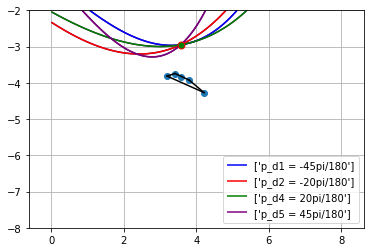

In [20]:
rng = np.random.default_rng()
#points = rng.random((30, 2))
points = np.array([[3.1886,-3.81288],[3.40957,-3.743],[3.5845,-3.8394],[3.7997,-3.9225],[4.21067,-4.26765]]) 
print(points)
print(points.shape)
hull = ConvexHull(points)

plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.xlim(2.0,5.0)
plt.ylim(-5,-2)

x_1 = [3.572468]
y_1 = [-2.9473]

#plt.figure(figsize=(3, 3))

plt.plot(x_1, y_1, marker="o", markersize=7, markeredgecolor="red", markerfacecolor="green")
plt.grid()


# plot barrier function generated 

X = np.linspace(0.0, 8.0, 1000)
Y = np.linspace(-8.0, -2.0, 1000)
x, y = np.meshgrid(X,Y)

F_1 = -1 + x**2*(5.19214363729817e-8*x**2 + 2.09536396763949e-11*x*y + 171.541900619942*x - 1.52265530046617e-8*y**2 + 0.58917544759039*y - 60.4062616006155) - 60.4062616006155*x**2 + x*y*(2.09536396763949e-11*x**2 - 2.96484865854312e-8*x*y + 0.589175447711705*x - 3.14741596959817e-7*y**2 - 8.51042475839934e-6*y - 38.7014427547366) - 38.7014427547366*x*y - 1.19*x*(-0.130928139544736*x**2 + 5.45108018586438e-7*x*y + 187.559493711542*x + 2.50362301493037e-6*y**2 - 11.0371518714231*y - 427.975616313624) + x*(171.386096133884*x**2 + 0.589176096390247*x*y + 102.383267266524*x - 5.53159696368869e-6*y**2 - 38.7014423317802*y - 5497.40358839888) - 4988.11260498566*x + y**2*(-1.52265530046617e-8*x**2 - 3.14741596959817e-7*x*y - 8.51090835145583e-6*x - 6.13425704430999e-6*y**2 - 1.45747656313363e-5*y + 22.1604017231757) + 22.1604017231757*y**2 - 1.19*y*(5.45173940195217e-7*x**2 + 2.50323079185415e-6*x*y - 11.037151871352*x + 5.85417283766059e-6*y**2 - 2.84910422778926e-6*y + 13.7868619186846) + y*(0.589176096347379*x**2 - 5.5315801160929e-6*x*y - 38.7014423316958*x - 7.60829995452022e-6*y**2 + 44.320799134509*y - 5921.14787769242) - 5937.55424337565*y - 13953.2139945847
F_2 = -1 + x**2*(-4.93241031802132e-7*x**2 + 4.9209620313867e-8*x*y + 42.6272545549973*x - 3.10808019296116e-8*y**2 - 0.0970214295409231*y + 112.112300476559) + 112.112300476559*x**2 + x*y*(4.9209620313867e-8*x**2 - 6.20368880728585e-8*x*y - 0.0970214340935906*x + 1.33312587141651e-7*y**2 + 3.78925725116895e-6*y - 15.4515065106265) - 15.4515065106265*x*y - 1.19*x*(0.02156040175476*x**2 - 4.3938242187287e-7*x*y + 97.4374500444572*x - 2.54011258423712e-7*y**2 - 4.04375700560463*y - 193.1496144003) + x*(42.6529114330855*x**2 - 0.0970219569586726*x*y + 340.175156959826*x + 3.47770704570447e-6*y**2 - 15.4515050217882*y - 2156.12108538067) - 1926.27304424431*x + y**2*(-3.10808019296116e-8*x**2 + 1.33312587141651e-7*x*y + 3.77998044322869e-6*x + 1.59478676629866e-6*y**2 + 1.79191901894676e-6*y + 2.43697238502757) + 2.43697238502757*y**2 + y*(-0.097021952752983*x**2 + 3.47696997646266e-6*x*y - 15.4515050207231*x + 6.6845112839001e-7*y**2 + 4.87394489812715*y - 2859.77509290254) - 1.19*y*(-4.39673999941672e-7*x**2 - 2.62426281265792e-7*x*y - 4.04375700470957*x - 9.44090664333407e-7*y**2 + 1.59153388655771e-7*y + 9.68684680736755) - 2871.30244060331*y - 13421.201237865
#F_3 = -1 + x**2*(7.15039123131779e-9*x**2 + 4.23848820434858e-9*x*y - 0.0298318411054296*x - 1.48193955073408e-8*y**2 - 0.00161968609269487*y + 0.416661951202714) + 0.416661951202714*x**2 + x*y*(4.23848820434858e-9*x**2 + 9.10261876188393e-9*x*y - 0.00161968375140182*x + 1.35851579918581e-8*y**2 - 1.19480451351108e-7*y + 0.261293594082864) + 0.261293594082864*x*y + x*(-0.0294035356409466*x**2 - 0.00161965256189055*x*y + 0.567197902444841*x - 1.1958268997424e-7*y**2 + 0.261293602267684*y - 11.6926521727914) - 1.19*x*(0.000359920558389045*x**2 + 2.6209673336657e-8*x*y - 0.223635293089322*x - 1.10839366693807e-8*y**2 + 0.0924102701091456*y - 6.03938119447313) - 4.50578855136835*x + y**2*(-1.48193955073408e-8*x**2 + 1.35851579918581e-8*x*y - 1.06392805337677e-7*x - 5.12164169069048e-8*y**2 + 1.85547440671036e-8*y + 0.0393167549270202) + 0.0393167549270202*y**2 + y*(-0.00161965359866651*x**2 - 1.27204765127051e-7*x*y + 0.26129360009395*x + 5.45937081090575e-9*y**2 + 0.0786334911062765*y - 79.4629114018944) - 1.19*y*(2.73059061877419e-8*x**2 - 6.4910199797844e-9*x*y + 0.0924102682824785*x - 1.10045153413427e-8*y**2 - 6.02995639790239e-9*y - 65.77821313539) - 1.18683777078027*y + 13.726560958685
F_4 = -1 + x**2*(2.79403239762618e-8*x**2 - 3.69693781052848e-8*x*y + 3.21530657196566*x + 2.48017820349513e-8*y**2 + 0.105622975562579*y + 13.6012201014625) + 13.6012201014625*x**2 + x*y*(-3.69693781052848e-8*x**2 + 5.44663254496279e-8*x*y + 0.105622976010982*x - 8.45232959673962e-8*y**2 + 3.53481826913738e-6*y + 4.69361592529395) + 4.69361592529395*x*y - 1.19*x*(-0.0234711604525812*x**2 - 5.22485955735491e-7*x*y - 9.31449921960964*x - 5.96507563319087e-9*y**2 - 1.42031251682446*y + 16.5729605124103) + x*(3.18737589102709*x**2 + 0.105622354252695*x*y + 16.1181859892257*x + 3.52729030204251e-6*y**2 + 4.69361481438146*y - 192.897395808644) - 212.619218818412*x + y**2*(2.48017820349513e-8*x**2 - 8.45232959673962e-8*x*y + 3.53438874204601e-6*x + 7.55032960898607e-8*y**2 - 1.63978019421662e-6*y + 3.04252031662172) + 3.04252031662172*y**2 - 1.19*y*(-5.22184402379937e-7*x**2 - 5.46484531531985e-9*x*y - 1.42031251695063*x + 2.68836122603619e-7*y**2 - 8.08650201609723e-6*y + 5.09669654366588) + y*(0.10562235416314*x**2 + 3.52831510321215e-6*x*y + 4.69361481423132*x - 1.31986520831831e-6*y**2 + 6.08503089007733*y - 393.089044517227) - 399.154113404189*y - 1677.79656506774
F_5 = -1 + x**2*(-2.99740133867674e-7*x**2 + 1.07358699820081e-7*x*y + 48.2665723815846*x - 3.58828776262698e-8*y**2 + 0.343305395475522*y + 0.628509325964991) + 0.628509325964991*x**2 + x*y*(1.07358699820081e-7*x**2 - 6.99449446089375e-8*x*y + 0.343305395364378*x + 2.37904671597981e-7*y**2 - 1.68248401361896e-6*y + 11.615595325377) + 11.615595325377*x*y - 1.19*x*(-0.0762895971455164*x**2 - 7.78724431242233e-7*x*y - 50.7181308096686*x + 3.64168330740293e-6*y**2 - 2.12122153143956*y + 143.495663493763) + x*(48.1757877609814*x**2 + 0.343304468682305*x*y - 59.097554601829*x + 2.64974100670327e-6*y**2 + 11.6155987151168*y - 859.09473086495) - 1029.85457042253*x + y**2*(-3.58828776262698e-8*x**2 + 2.37904671597981e-7*x*y - 1.68386212910622e-6*x - 4.21666582834553e-6*y**2 - 8.30819560347152e-6*y + 0.773106831227127) + 0.773106831227127*y**2 - 1.19*y*(-7.78806358983614e-7*x**2 + 3.64101333815993e-6*x*y - 2.12122153147763*x - 1.72118808627486e-6*y**2 + 9.79274811895333e-6*y + 5.50275097623725) + y*(0.343304468695955*x**2 + 2.65032185879136e-6*x*y + 11.6155987150715*x - 1.03564094261386e-5*y**2 + 1.54622528470737*y - 904.448871825598) - 910.99714548732*y - 1877.95283259706


#F_5 = -1 + x**2*(-1.84536777983869e-9*x**2 - 2.61113387845714e-9*x*y - 0.0427536413764992*x - 2.23703172807076e-9*y**2 + 4.4614282036296e-5*y + 2.29952381926249) + 2.29952381926249*x**2 + x*y*(-2.61113387845714e-9*x**2 - 2.72235102832299e-9*x*y + 4.46143941401326e-5*x - 4.51336754285914e-9*y**2 - 9.02953366512302e-7*y - 0.106212552270655) - 0.106212552270655*x*y + x*(-0.0427655266015825*x**2 + 4.50317958211314e-5*x*y + 4.5987184133237*x - 1.06831041179082e-6*y**2 - 0.106212610717267*y - 60.3637344675026) - 1.19*x*(-9.987584103594e-6*x**2 + 3.50757715125018e-7*x*y - 0.000276579975514501*x - 1.39706120381233e-7*y**2 - 0.000142469400540771*y + 0.00518669211329728) - 60.3699066311175*x + y**2*(-2.23703172807076e-9*x**2 - 4.51336754285914e-9*x*y - 9.02060128537153e-7*x + 1.04733367215724e-8*y**2 + 1.73101346186203e-8*y - 0.431857406803344) - 0.431857406803344*y**2 - 1.19*y*(3.50850255995048e-7*x**2 - 1.3892674344578e-7*x*y - 0.000142469400902833*x + 2.12708510958567e-7*y**2 + 7.21725197841537e-8*y - 0.0151556425586101) + y*(4.50317938409301e-5*x**2 - 1.06827619121278e-6*x*y - 0.106212610717698*x + 2.70433262659315e-7*y**2 - 0.863714709143718*y - 57.6281557817098) - 57.6101205670651*y - 11.1993112214814

#F = np.array([F_1,F_2,F_3,F_4,F_5])
#print(F_1.shape)

plt.contour(x,y,F_1,[0])
CS1 = plt.contour(x,y,F_1,[0],colors = ['blue'])
label1 = ['p_d1 = -45pi/180']
CS1.collections[0].set_label(label1)


plt.contour(x,y,F_2,[0])
CS2 = plt.contour(x,y,F_2,[0],colors = ['red'])
label2 = ['p_d2 = -20pi/180']
CS2.collections[0].set_label(label2)

#plt.contour(x,y,F_3,[0])
#CS3 = plt.contour(x,y,F_3,[0],colors = ['black'])
#label3 = ['p_d3 = 0']
#CS3.collections[0].set_label(label3)

plt.contour(x,y,F_4,[0])
CS4 = plt.contour(x,y,F_4,[0],colors = ['green'])
label4 = ['p_d4 = 20pi/180']
CS4.collections[0].set_label(label4)

plt.contour(x,y,F_5,[0])
CS5 = plt.contour(x,y,F_5,[0],colors = ['purple'])
label5 = ['p_d5 = 45pi/180']
CS5.collections[0].set_label(label5)

#CS = plt.contour(x,y,F,[0])
#labels = ['p_d1 = -45pi/180','p_d2 = -20pi/180','p_d3 = 0','p_d4 = 20pi/180','p_d5 = 45pi/180']
#for i in range(len(labels)):
#    CS.collections[i].set_label(labels[i])
    

plt.axis('equal')
plt.legend(loc='lower right')
plt.show()

In [1]:
# latest version
# define states
x,y,p = sympy.symbols('x y p')
K = 50
V = 1.0
p_d1 = -45*np.pi/180
p_d2 = -20*np.pi/180
p_d3 = 0
p_d4 = 20*np.pi/180
p_d5 = 45*np.pi/180

angle = 0

# taylor approximation around 0 (should be changed later)
#f = sympy.Matrix([[-V*p +(V*p**3)/6],[V - (V*p**2)/2],[-K*(p - p_d4)]])
f = sympy.Matrix([[-(V*math.cos(angle)*p - (V*math.cos(angle))/6*p**3)],[V*math.cos(angle) - (V*math.cos(angle)/2)*p**2],[-K*(p - p_d3)]])
#print(f_1)
#print(f_2)
# polynomial basis
b1 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b1 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b1 = sympy.Matrix([[1,x,y,p]]).transpose()


Q = sympy.MatrixSymbol('Q',10,10)
#Q = sympy.MatrixSymbol('Q',4,4)
#Q = sympy.MatrixSymbol('Q',9,9)


# partial derivative
db1_dx = sympy.diff(b1,x)
#print(db1_dx)
db1_dy = sympy.diff(b1,y)
db1_dp = sympy.diff(b1,p)


########## parameterization step
# V
V = (b1.T @ Q @ b1).as_explicit()
SOS_V_para_poly = sympy.Poly(V[0],x,y,p)
B = sympy.Matrix([
            [db1_dx, db1_dy,db1_dp]])
print(B.shape)
ne_Vdot_compute = (- 2 * b1.T @ Q @ B @ f).as_explicit()
ne_Vdot_compute_poly = sympy.Poly(ne_Vdot_compute[0],x, y, p)

print('check coeff of ne_Vdot_compute_poly:')
print(ne_Vdot_compute_poly)
    

# -V_dot
#b2 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
b2 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b2 = sympy.Matrix([[1,x,y,p]]).transpose()
#G = sympy.MatrixSymbol('G', 4, 4)
G = sympy.MatrixSymbol('G', 10, 10)
#G = G = sympy.MatrixSymbol('G', 9, 9)
SOS_of_ne_V_dot = (b2.T @ G @ b2).as_explicit()
SOS_of_ne_V_dot_poly = sympy.Poly(SOS_of_ne_V_dot[0], x, y, p)

print('\ncheck coeff of SOS_of_ne_V_dot_poly:')
print(SOS_of_ne_V_dot_poly)

b2_sqr = [b*b for b in b2]
for b_sqr in b2_sqr:
    coeff = SOS_of_ne_V_dot_poly.coeff_monomial(b_sqr)
    if coeff is sympy.S.Zero:
        print('WARNING: digonal coeff is zero for',b_sqr, ' not PSD for sure!')


# largrange multiplier
b3 = sympy.Matrix([[1,x,y,p]]).transpose()
#b3 = sympy.Matrix([[x,y,p]]).transpose()
J = sympy.MatrixSymbol('J',4,4)
#J = sympy.MatrixSymbol('J',3,3)
SOS_mutiplier_para = (b3.T @ J @ b3).as_explicit()
SOS_mutiplier_para_poly = sympy.Poly(SOS_mutiplier_para[0],x,y,p)


### dealing with obstacle constraint SOS

# obstacle constraint SOS paratrization
b4 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b4 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b4 = sympy.Matrix([[1,x,y,p]]).transpose()
#M = sympy.MatrixSymbol('M',10,10)
M = sympy.MatrixSymbol('M',10,10)
#M = sympy.MatrixSymbol('M',4,4)
SOS_constraint_para = (b4.T @ M @ b4).as_explicit()
SOS_constraint_para_poly = sympy.Poly(SOS_constraint_para[0],x,y,p)


#print('\ncheck coeff of SOS_constraint_para_poly:{}'.format(SOS_constraint_para_poly))


# obstacle constraint SOS computed from V and multiplier
epsilon_1 = 1e-6
SOS_constraint_compute_poly = (SOS_V_para_poly - (1 + epsilon_1)) - (SOS_mutiplier_para_poly * (0.4 - (x - 2)**2-(y - 2)**2))
constraint_list_V_Vdot = []
constraint_list_obstacle = []


#print('\ncheck coeff of SOS_constraint_compute_poly:{}'.format(SOS_constraint_compute_poly))

max_order = 10
# deal with V and -V_dot adding coeff matching constraint
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            # check if b2.T @ G b2 has coeff
            coeff_V_dot_para = SOS_of_ne_V_dot_poly.coeff_monomial(monomial)
            #print('coeff for {} in SOS_of_ne_V_dot_poly is {}'.format(monomial,coeff_V_dot_para))
            # check if - 2 * b1.T @ Q @ B @ f has coeff
            coeff_V_dot_compu = ne_Vdot_compute_poly.coeff_monomial(monomial)
            #print('coeff for {} in ne_Vdot_compute_poly is {}'.format(monomial,coeff_V_dot_compu))
            
            # continue if both do not contain
            if coeff_V_dot_para is sympy.S.Zero and coeff_V_dot_compu is sympy.S.Zero:
                continue
            
            ## should be modified
            if coeff_V_dot_para is sympy.S.Zero and not coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_V_dot_compu)
                constraint_list_V_Vdot.append(constrain)
            ## should be modified
            if not coeff_V_dot_para is sympy.S.Zero and coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_V_dot_para)
                constraint_list_V_Vdot.append(constrain)
                
            if not coeff_V_dot_para is sympy.S.Zero and not coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_V_dot_compu,coeff_V_dot_para)
                constraint_list_V_Vdot.append(constrain)

            
print('\nConstraints V_Vdot (copy):', ','.join(constraint_list_V_Vdot))                

# delta with obstacle SOS coeff matching
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            
            coeff_constraint_para = SOS_constraint_para_poly.coeff_monomial(monomial)
            coeff_constraint_compute = SOS_constraint_compute_poly.coeff_monomial(monomial)
            
            if coeff_constraint_para is sympy.S.Zero and coeff_constraint_compute is sympy.S.Zero:
                #print(monomial)
                continue
            
            ## should be modified
            if coeff_constraint_para is sympy.S.Zero and not coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_constraint_compute)
                constraint_list_obstacle.append(constrain)
            ## should be modified
            if not coeff_constraint_para is sympy.S.Zero and coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_constraint_para)
                constraint_list_obstacle.append(constrain)
                
            if not coeff_constraint_para is sympy.S.Zero and not coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_constraint_compute,coeff_constraint_para)
                constraint_list_obstacle.append(constrain)

print('\nConstraints obstacle SOS (copy):', ','.join(constraint_list_obstacle))

NameError: name 'sympy' is not defined

In [ ]:
# solve SOS as SDP based on constraint obtained earilier
Q = cp.Variable((10,10), symmetric=True)
G = cp.Variable((10,10), symmetric=True)
M = cp.Variable((10,10), symmetric = True)
J = cp.Variable((4,4), symmetric = True)

# make sure positive definite , sufficient condition
#epsilon = 1e-8
#constraints = [Q >> 0]
constraints = [G >> 0]
constraints += [M >> 0]
constraints += [J >> 0]

# equaility constraint for initial condition
x_0 = 0.0
y_0 = 0.0
p_0 = 0.0

b_0 = np.array([[1,x_0,y_0,p_0,x_0**2,x_0*y_0,y_0**2,x_0*p_0,y_0*p_0,p_0**2]]).transpose()
#print(b_0.T @ Q @ b_0)
#b1 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#constraints += 

constraints += [b_0.T @ Q @ b_0 == 0]


# V Vdot coeff matching constraint

# p_d1
constraints += [-2.0*Q[0, 2] + 78.5398163397448*Q[0, 3]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] + 157.07963267949*Q[0, 9] - 2.0*Q[3, 2] + 78.5398163397448*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] + 157.07963267949*Q[3, 9] - 2.0*Q[9, 2] + 78.5398163397448*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8] + 157.07963267949*Q[9, 9]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] + 78.5398163397448*Q[0, 8] - 2.0*Q[2, 2] + 78.5398163397448*Q[2, 3]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] + 157.07963267949*Q[2, 9] - 4.0*Q[3, 6] + 78.5398163397448*Q[3, 8] - 2.0*Q[8, 2] + 78.5398163397448*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] + 157.07963267949*Q[8, 9] - 4.0*Q[9, 6] + 78.5398163397448*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] + 78.5398163397448*Q[2, 8] - 2.0*Q[6, 2] + 78.5398163397448*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] + 157.07963267949*Q[6, 9] - 4.0*Q[8, 6] + 78.5398163397448*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6] + 78.5398163397448*Q[6, 8]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] + 78.5398163397448*Q[0, 7] - 2.0*Q[1, 2] + 78.5398163397448*Q[1, 3]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] + 157.07963267949*Q[1, 9] - 2.0*Q[3, 5] + 78.5398163397448*Q[3, 7] - 2.0*Q[7, 2] + 78.5398163397448*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] + 157.07963267949*Q[7, 9] - 2.0*Q[9, 5] + 78.5398163397448*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] + 78.5398163397448*Q[1, 8] - 2.0*Q[2, 5] + 78.5398163397448*Q[2, 7] - 2.0*Q[5, 2] + 78.5398163397448*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] + 157.07963267949*Q[5, 9] - 4.0*Q[7, 6] + 78.5398163397448*Q[7, 8] - 2.0*Q[8, 5] + 78.5398163397448*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] + 78.5398163397448*Q[5, 8] - 2.0*Q[6, 5] + 78.5398163397448*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] + 78.5398163397448*Q[1, 7] - 2.0*Q[4, 2] + 78.5398163397448*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] + 157.07963267949*Q[4, 9] - 2.0*Q[7, 5] + 78.5398163397448*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] + 78.5398163397448*Q[4, 8] - 2.0*Q[5, 5] + 78.5398163397448*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5] + 78.5398163397448*Q[4, 7]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]

# p_d2
#constraints += [-2.0*Q[0, 2] + 34.9065850398866*Q[0, 3]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] + 69.8131700797732*Q[0, 9] - 2.0*Q[3, 2] + 34.9065850398866*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] + 69.8131700797732*Q[3, 9] - 2.0*Q[9, 2] + 34.9065850398866*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8] + 69.8131700797732*Q[9, 9]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] + 34.9065850398866*Q[0, 8] - 2.0*Q[2, 2] + 34.9065850398866*Q[2, 3]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] + 69.8131700797732*Q[2, 9] - 4.0*Q[3, 6] + 34.9065850398866*Q[3, 8] - 2.0*Q[8, 2] + 34.9065850398866*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] + 69.8131700797732*Q[8, 9] - 4.0*Q[9, 6] + 34.9065850398866*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] + 34.9065850398866*Q[2, 8] - 2.0*Q[6, 2] + 34.9065850398866*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] + 69.8131700797732*Q[6, 9] - 4.0*Q[8, 6] + 34.9065850398866*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6] + 34.9065850398866*Q[6, 8]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] + 34.9065850398866*Q[0, 7] - 2.0*Q[1, 2] + 34.9065850398866*Q[1, 3]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] + 69.8131700797732*Q[1, 9] - 2.0*Q[3, 5] + 34.9065850398866*Q[3, 7] - 2.0*Q[7, 2] + 34.9065850398866*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] + 69.8131700797732*Q[7, 9] - 2.0*Q[9, 5] + 34.9065850398866*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] + 34.9065850398866*Q[1, 8] - 2.0*Q[2, 5] + 34.9065850398866*Q[2, 7] - 2.0*Q[5, 2] + 34.9065850398866*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] + 69.8131700797732*Q[5, 9] - 4.0*Q[7, 6] + 34.9065850398866*Q[7, 8] - 2.0*Q[8, 5] + 34.9065850398866*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] + 34.9065850398866*Q[5, 8] - 2.0*Q[6, 5] + 34.9065850398866*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] + 34.9065850398866*Q[1, 7] - 2.0*Q[4, 2] + 34.9065850398866*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] + 69.8131700797732*Q[4, 9] - 2.0*Q[7, 5] + 34.9065850398866*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] + 34.9065850398866*Q[4, 8] - 2.0*Q[5, 5] + 34.9065850398866*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5] + 34.9065850398866*Q[4, 7]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]

# p_d3

#constraints += [-2.0*Q[0, 2]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] - 2.0*Q[3, 2]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] - 2.0*Q[9, 2]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] - 2.0*Q[2, 2]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] - 4.0*Q[3, 6] - 2.0*Q[8, 2]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] - 4.0*Q[9, 6]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] - 2.0*Q[6, 2]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] - 4.0*Q[8, 6]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] - 2.0*Q[1, 2]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] - 2.0*Q[3, 5] - 2.0*Q[7, 2]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] - 2.0*Q[9, 5]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] - 2.0*Q[2, 5] - 2.0*Q[5, 2]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] - 4.0*Q[7, 6] - 2.0*Q[8, 5]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] - 2.0*Q[6, 5]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] - 2.0*Q[4, 2]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] - 2.0*Q[7, 5]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] - 2.0*Q[5, 5]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]


# p_d4
#constraints += [-2.0*Q[0, 2] - 34.9065850398866*Q[0, 3]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] - 69.8131700797732*Q[0, 9] - 2.0*Q[3, 2] - 34.9065850398866*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] - 69.8131700797732*Q[3, 9] - 2.0*Q[9, 2] - 34.9065850398866*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8] - 69.8131700797732*Q[9, 9]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] - 34.9065850398866*Q[0, 8] - 2.0*Q[2, 2] - 34.9065850398866*Q[2, 3]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] - 69.8131700797732*Q[2, 9] - 4.0*Q[3, 6] - 34.9065850398866*Q[3, 8] - 2.0*Q[8, 2] - 34.9065850398866*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] - 69.8131700797732*Q[8, 9] - 4.0*Q[9, 6] - 34.9065850398866*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] - 34.9065850398866*Q[2, 8] - 2.0*Q[6, 2] - 34.9065850398866*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] - 69.8131700797732*Q[6, 9] - 4.0*Q[8, 6] - 34.9065850398866*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6] - 34.9065850398866*Q[6, 8]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] - 34.9065850398866*Q[0, 7] - 2.0*Q[1, 2] - 34.9065850398866*Q[1, 3]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] - 69.8131700797732*Q[1, 9] - 2.0*Q[3, 5] - 34.9065850398866*Q[3, 7] - 2.0*Q[7, 2] - 34.9065850398866*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] - 69.8131700797732*Q[7, 9] - 2.0*Q[9, 5] - 34.9065850398866*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] - 34.9065850398866*Q[1, 8] - 2.0*Q[2, 5] - 34.9065850398866*Q[2, 7] - 2.0*Q[5, 2] - 34.9065850398866*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] - 69.8131700797732*Q[5, 9] - 4.0*Q[7, 6] - 34.9065850398866*Q[7, 8] - 2.0*Q[8, 5] - 34.9065850398866*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] - 34.9065850398866*Q[5, 8] - 2.0*Q[6, 5] - 34.9065850398866*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] - 34.9065850398866*Q[1, 7] - 2.0*Q[4, 2] - 34.9065850398866*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] - 69.8131700797732*Q[4, 9] - 2.0*Q[7, 5] - 34.9065850398866*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] - 34.9065850398866*Q[4, 8] - 2.0*Q[5, 5] - 34.9065850398866*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5] - 34.9065850398866*Q[4, 7]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]

# p_d5
#constraints += [-2.0*Q[0, 2] - 78.5398163397448*Q[0, 3]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] - 157.07963267949*Q[0, 9] - 2.0*Q[3, 2] - 78.5398163397448*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] - 157.07963267949*Q[3, 9] - 2.0*Q[9, 2] - 78.5398163397448*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8] - 157.07963267949*Q[9, 9]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] - 78.5398163397448*Q[0, 8] - 2.0*Q[2, 2] - 78.5398163397448*Q[2, 3]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] - 157.07963267949*Q[2, 9] - 4.0*Q[3, 6] - 78.5398163397448*Q[3, 8] - 2.0*Q[8, 2] - 78.5398163397448*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] - 157.07963267949*Q[8, 9] - 4.0*Q[9, 6] - 78.5398163397448*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] - 78.5398163397448*Q[2, 8] - 2.0*Q[6, 2] - 78.5398163397448*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] - 157.07963267949*Q[6, 9] - 4.0*Q[8, 6] - 78.5398163397448*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6] - 78.5398163397448*Q[6, 8]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] - 78.5398163397448*Q[0, 7] - 2.0*Q[1, 2] - 78.5398163397448*Q[1, 3]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] - 157.07963267949*Q[1, 9] - 2.0*Q[3, 5] - 78.5398163397448*Q[3, 7] - 2.0*Q[7, 2] - 78.5398163397448*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] - 157.07963267949*Q[7, 9] - 2.0*Q[9, 5] - 78.5398163397448*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] - 78.5398163397448*Q[1, 8] - 2.0*Q[2, 5] - 78.5398163397448*Q[2, 7] - 2.0*Q[5, 2] - 78.5398163397448*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] - 157.07963267949*Q[5, 9] - 4.0*Q[7, 6] - 78.5398163397448*Q[7, 8] - 2.0*Q[8, 5] - 78.5398163397448*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] - 78.5398163397448*Q[5, 8] - 2.0*Q[6, 5] - 78.5398163397448*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] - 78.5398163397448*Q[1, 7] - 2.0*Q[4, 2] - 78.5398163397448*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] - 157.07963267949*Q[4, 9] - 2.0*Q[7, 5] - 78.5398163397448*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] - 78.5398163397448*Q[4, 8] - 2.0*Q[5, 5] - 78.5398163397448*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5] - 78.5398163397448*Q[4, 7]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]





prob = cp.Problem(cp.Minimize(1),constraints)
prob.solve(verbose=False)

# Print result
print("status:", prob.status)
print("The optimal value is", prob.value)
print("A solution Q is")
print(Q.value)
print(J.value)

V_sol = b1.T @ Q.value @ b1

print(V_sol)
